In [1]:
import tensorflow as tf
print("Num GPUs Available: ", len(tf.config.experimental.list_physical_devices('GPU')))
print(tf.test.is_built_with_cuda())
print(tf.version.VERSION)

for device in tf.config.list_physical_devices('GPU'):
    tf.config.experimental.set_memory_growth(device, True)

import sys
sys.version


C:\Users\Chanv\anaconda3\envs\tf2\lib\site-packages\requests\__init__.py:109: RequestsDependencyWarning: urllib3 (1.26.14) or chardet (None)/charset_normalizer (3.1.0) doesn't match a supported version!
  warnings.warn(


Num GPUs Available:  1
True
2.10.1


'3.9.16 | packaged by conda-forge | (main, Feb  1 2023, 21:28:38) [MSC v.1929 64 bit (AMD64)]'

In [2]:
DATASET_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train'
SINGLE_TEST_PATH = 'C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Test/Test007'
BATCH_SIZE = 8
EPOCHS = 3
MODEL_PATH = "C:/Users/Chanv/Projects/FYP/UCSDPed/ped2weights/simpleAutoencoder2.hdf5"

In [3]:
from os import listdir
from os.path import isfile, join, isdir
from PIL import Image
import numpy as np
import matplotlib.pyplot as plt

In [4]:
def evaluate(sequences, reconstructed_sequences):
    sequences_reconstruction_cost = np.array([np.linalg.norm(np.subtract(sequences[i],reconstructed_sequences[i])) for i in range(0,len(sequences))])
    sa = (sequences_reconstruction_cost - np.min(sequences_reconstruction_cost)) / (np.max(sequences_reconstruction_cost) - np.min(sequences_reconstruction_cost))
    sr = 1.0 - sa
    # ( mse - min_mse ) / max_mse - min_mse
    # plot the regularity scores
    sequence_numbers = [i for i in range(1, len(sequences) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    plt.plot(sequence_numbers, sr)
    plt.ylabel('Regularity score')
    plt.xlabel('Sequence Number')
    plt.show()

    return sr

In [5]:
def plot_mse_change(mse_values, mean_mse=0, legend = None, doPlotThreshold = False):

    mse_values = mse_values[:, 0]
    # Plot MSE against frame number
    sequence_numbers = [i for i in range(1, len(mse_values) + 1)]
    plt.xticks(range(min(sequence_numbers), max(sequence_numbers), 2))
    
    plt.plot(sequence_numbers, mse_values, color='g', marker='o', linestyle='-')
    plt.xlabel('Sequence Number')
    plt.ylabel('Mean Squared Error (MSE)')
    plt.title('MSE Against Sequence Number')
    plt.grid(True)

    if doPlotThreshold:
        plt.axhline(y=mean_mse, color='c', linestyle='--', label='Mean MSE')
        plt.legend(legend)
    plt.show()

In [6]:
import cv2
import os
import numpy as np

def preprocess_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []

    
    # Loop through each video sequence in the dataset
    for sequence_folder in os.listdir(data_path):
        sequence_path = os.path.join(data_path, sequence_folder)
        if sequence_path.endswith("Store"):
            continue
        print(sequence_path)
        
        frames = []
        # Read frames from the video sequence
        for frame_file in sorted(os.listdir(sequence_path)):
            if frame_file.endswith("Store"):
                continue
            
            if len(frames) == 10:
                preprocessed_data.append(frames)
                frames = []
           
            frame_path = os.path.join(sequence_path, frame_file)
            frame = cv2.imread(frame_path)
            frame = cv2.resize(frame, output_shape)  # Resize frame
            frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
            frames.append(frame)
        preprocessed_data.append(frames)

    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)
    
    return preprocessed_data


# Path to the Ped2 dataset
data_path = DATASET_PATH

# Preprocess the Ped2 dataset
preprocessed_data = preprocess_dataset(data_path)


# Check the shape of the preprocessed data
print("Preprocessed dataset shape:", preprocessed_data.shape)


C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train001
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train002
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train003
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train004
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train005
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train006
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train007
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train008
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train009
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train010
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train011
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train012
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train013
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train014
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train015
C:/Users/Chanv/Projects/FYP/UCSDPed/UCSDped2/Train\Train016
Preprocessed dataset shape: (150, 10, 12

In [7]:
import keras
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Input, Conv3D, MaxPooling3D, UpSampling3D

def get_model2(input_shape = (10, 128, 128, 3)):

    autoencoder = Sequential()

    # Encoder
    autoencoder.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same', input_shape=input_shape))
    autoencoder.add(MaxPooling3D((1, 2, 2), padding='same'))
    autoencoder.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    autoencoder.add(MaxPooling3D((1, 2, 2), padding='same'))

    # Decoder
    autoencoder.add(Conv3D(64, (3, 3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling3D((1, 2, 2)))  # Upsampling to match original input shape
    autoencoder.add(Conv3D(128, (3, 3, 3), activation='relu', padding='same'))
    autoencoder.add(UpSampling3D((1, 2, 2)))  # Upsampling to match original input shape
    autoencoder.add(Conv3D(3, (3, 3, 3), activation='sigmoid', padding='same'))  # Output RGB images

    autoencoder.compile(optimizer='adam', loss='mse')
    autoencoder.summary()
    return autoencoder

In [8]:
seq2 = get_model2()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv3d (Conv3D)             (None, 10, 128, 128, 128  10496     
                             )                                   
                                                                 
 max_pooling3d (MaxPooling3D  (None, 10, 64, 64, 128)  0         
 )                                                               
                                                                 
 conv3d_1 (Conv3D)           (None, 10, 64, 64, 64)    221248    
                                                                 
 max_pooling3d_1 (MaxPooling  (None, 10, 32, 32, 64)   0         
 3D)                                                             
                                                                 
 conv3d_2 (Conv3D)           (None, 10, 32, 32, 64)    110656    
                                                        

In [9]:
from sklearn.model_selection import train_test_split

# Build autoencoder model
train_data, val_data = train_test_split(preprocessed_data, test_size=0.2, random_state=42)




In [10]:
from keras.models import load_model

# Train autoencoder
# seq2.compile(loss='mse', optimizer=keras.optimizers.Adam(learning_rate=1e-4, epsilon=1e-6))
# seq2.fit(train_data, train_data, validation_data=(val_data, val_data), epochs=25, batch_size=BATCH_SIZE)
# seq2.save(MODEL_PATH)

seq2 = load_model(MODEL_PATH)





# Testing

In [11]:
test_path = SINGLE_TEST_PATH

In [12]:
def get_mse(sequences, reconstructed_sequences):
    mse = np.mean(np.square(sequences - reconstructed_sequences), axis=(1,2,3))
    return mse

In [13]:
def preprocess_test_dataset(data_path, output_shape=(128, 128)):
    # Create a list to store preprocessed images
    preprocessed_data = []
        
    # Read frames from the video sequence
    frames = []
    for frame_file in sorted(os.listdir(data_path)):
        
        if frame_file.endswith("Store"):
                continue
        
        if len(frames) == 10:
            preprocessed_data.append(frames)
            frames = []
        
        frame_path = os.path.join(data_path, frame_file)
        
        frame = cv2.imread(frame_path)
        frame = cv2.resize(frame, output_shape)  # Resize frame
        frame = frame.astype(np.float32) / 255.0  # Normalize pixel values
        
        frames.append(frame)
        
    preprocessed_data.append(frames)


    # Convert the list to a numpy array
    preprocessed_data = np.array(preprocessed_data)
    
    return preprocessed_data

test_data = preprocess_test_dataset(test_path)
print("Preprocessed dataset shape:", preprocessed_data.shape)

Preprocessed dataset shape: (150, 10, 128, 128, 3)


In [14]:
predicted_sequences = seq2.predict(test_data)

1/1 [==============================] - 4s 4s/step


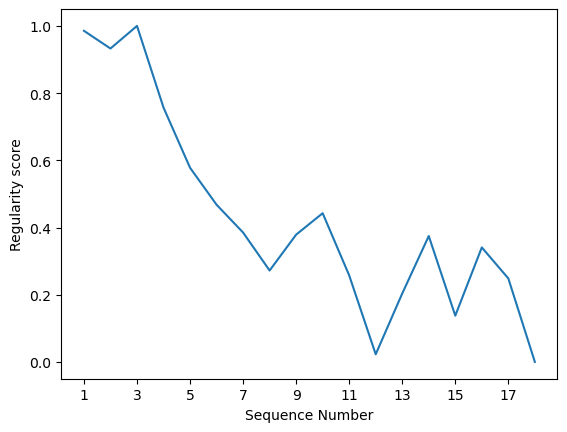

In [15]:
reg = evaluate(test_data, predicted_sequences)

In [16]:
mse = get_mse(test_data, predicted_sequences)

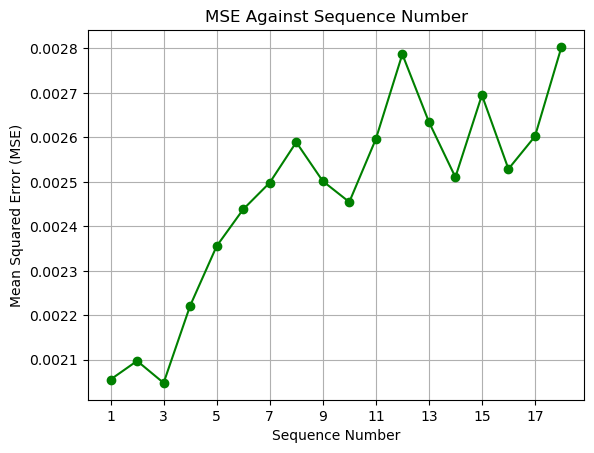

In [17]:
plot_mse_change(mse)

In [18]:
print(mse2)

NameError: name 'mse2' is not defined